# LGD EAD model Data Preparation

In [1]:
%load_ext autoreload
%autoreload 2

## Change to project directory (google colab)

In [2]:
import os
os.chdir('/content/drive/MyDrive/projects/credit-risk-modelling-udemy/notebooks')
os.listdir('../')

['venv-hpx360-win',
 'data',
 'src',
 '.git',
 'requirements.txt',
 'README.md',
 'src.egg-info',
 'setup.py',
 'reports',
 'outputs',
 'notebooks',
 '.gitignore']

In [4]:
!pip install -e ../.

Obtaining file:///content/drive/MyDrive/projects/credit-risk-modelling-udemy
  Running setup.py develop for src


## Some imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import src
from src.project.config import PROJECT_DIR

## Load Data

In [25]:
fpath = os.path.join(PROJECT_DIR, 'outputs', 'loan_data_general_preprocessed_nb2.pkl')
loan_data = pd.read_pickle(fpath)
loan_data.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,addr_state:IA,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:ME,addr_state:MD,addr_state:MA,addr_state:MI,addr_state:MN,addr_state:MS,addr_state:MO,addr_state:MT,addr_state:NE,addr_state:NV,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NY,addr_state:NC,addr_state:ND,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VT,addr_state:VA,addr_state:WA,addr_state:WV,addr_state:WI,addr_state:WY,addr_state:DC,initial_list_status:f,initial_list_status:w,good_bad_loan
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgrade...,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use thi...,car,bike,309xx,GA,1.00,0.0,1999-04-01,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,2001-11-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for proper...,other,personel,917xx,CA,20.00,0.0,1996-02-01,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combini...,other,Personal,972xx,OR,17.94,0.0,1996-01-01,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


* When a borrower has defaulted, he/she can repay the loan even after defaulting (in some time), and hence, the amount that the lender thought was lost is recovered.
* Hence, it is a good practice to examine those borrowers who have had enough time post default to repay the loan, when modelling Loss Given Default (LGD) and Exposure at Default (EAD)

In [26]:
loan_data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [27]:
df = loan_data.loc[loan_data['loan_status'].isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off'])].reset_index(drop=True)
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,addr_state:IA,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:ME,addr_state:MD,addr_state:MA,addr_state:MI,addr_state:MN,addr_state:MS,addr_state:MO,addr_state:MT,addr_state:NE,addr_state:NV,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NY,addr_state:NC,addr_state:ND,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VT,addr_state:VA,addr_state:WA,addr_state:WV,addr_state:WI,addr_state:WY,addr_state:DC,initial_list_status:f,initial_list_status:w,good_bad_loan
0,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use thi...,car,bike,309xx,GA,1.00,0.0,1999-04-01,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.71,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,8,1071795,1306957,5600,5600,5600.0,60 months,21.28,152.39,F,F2,NaN,4 years,OWN,40000.0,Source Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I own a small hom...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,2004-04-01,2.0,NaN,NaN,11.0,0.0,5210,32.6,13.0,f,0.0,0.0,646.02,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,9,1071570,1306721,5375,5375,5350.0,60 months,12.69,121.45,B,B5,Starbucks,< 1 year,RENT,15000.0,Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/16/11 > I'm trying to bui...,other,Building my credit history.,774xx,TX,18.08,0.0,2004-09-01,0.0,NaN,NaN,2.0,0.0,9279,36.5,3.0,f,0.0,0.0,1476.19,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,12,1064687,1298717,9000,9000,9000.0,36 months,13.49,305.38,C,C1,Va. Dept of Conservation/Recreation,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/15/11 > Plan to pay off 2...,debt_consolidation,freedom,245xx,VA,10.08,0.0,2004-04-01,1.0,NaN,NaN,4.0,0.0,10452,91.7,9.0,f,0.0,0.0,2270.70,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,14,1069057,1303503,10000,10000,10000.0,36 months,10.65,325.74,B,B2,SFMTA,3 years,RENT,100000.0,Source Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,other,Other Loan,951xx,CA,7.06,0.0,1991-05-01,2.0,NaN,NaN,14.0,0.0,11997,55.5,29.0,f,0.0,0.0,7471.99,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Missing Values

In [28]:
miss_df = df.isna().sum()
miss_df[miss_df != 0]

emp_title                       3287
emp_length                      2337
desc                           27427
title                              3
earliest_cr_line                   3
mths_since_last_delinq         23950
mths_since_last_record         37821
revol_util                        53
last_pymnt_d                     376
next_pymnt_d                   42475
last_credit_pull_d                 6
collections_12_mths_ex_med        28
mths_since_last_major_derog    35283
tot_coll_amt                   10780
tot_cur_bal                    10780
dtype: int64

* For `mths_since_last_delinq` and `mths_since_last_record` columns, when creating dummy variables, we created another category called **missing**
* LGD and EAD models are not required to be easy to comprehend, since only risk modellers use them.
* Hence for LGD and EAD models, we would only create dummy variables for the categorical columns, and this time we won't even care about grouping categories according to WoE criterion (or any other criterion)
* Also for continous columns, there is no need for fine-classing or coarse-classing

$EL = PD \times LGD \times EAD$ 


**LGD**

* % of exposure that is lost or cannot be recovered once a default occurs

* Filling missing values taking the most conservative approach to risk

In [29]:
df['mths_since_last_delinq'].fillna(0, inplace=True)
df['mths_since_last_record'].fillna(0, inplace=True)

## Dependant Variable

* For the LGD model, we will model the recovery rate, which is the amount that can be recovered once a default has occured. Then the LGD will just be 1 - recovery_rate

In [30]:
df['recovery_rate'] = df['recoveries']/df['funded_amnt']
df['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

* It happens sometimes that the recovery rate falls beyond the 0-1 range due to some accounting calculations. We can truncate these to 0 or 1. 

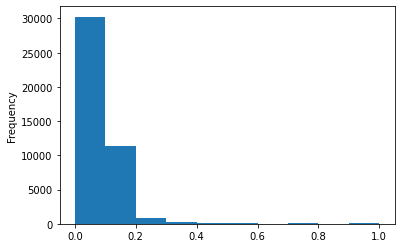

In [31]:
df.loc[df['recovery_rate'] > 1, 'recovery_rate'] =  1
df.loc[df['recovery_rate'] < 0, 'recovery_rate'] =  0
df['recovery_rate'].plot(kind='hist');

* For the EAD model, when the borrower defaults, he/she may have already paid back a certain proportion of the original funded amount which is the credit conversion factor. Then the EAD can be modelled as

$EAD = \text{total funded amount} \times \text{credit conversion factor}$

* We will model **credit conversion factor**
* **total_rec_prncpl** is the payments made on the principal of the **funded_amnt**

In [32]:
df['ccf'] = (df['funded_amnt'] - df['total_rec_prncp'])/df['funded_amnt']
df['ccf'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: ccf, dtype: float64

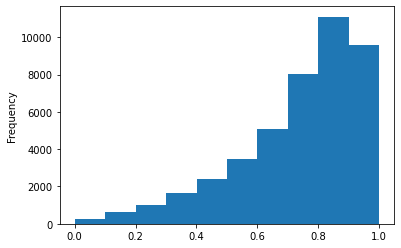

In [33]:
df['ccf'].plot(kind='hist');

In [34]:
df['recovery_rate_0_1'] = (df['recovery_rate'] != 0).astype(int)


## Save the output

In [35]:
out_file = os.path.join(PROJECT_DIR, 'outputs', 'loan_data_2007_2014_defaults_for_lgd_ead_nb8.pkl')
df.to_pickle(out_file)